In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
#------------------------------------
# load dataset
#------------------------------------

df = pd.read_csv('/workspaces/End_to_end_insurance_price_predection/data/processed/insurance_cleaned.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [27]:
#---------------------------------------
# Recheck dataset
#---------------------------------------
print(df.isnull().sum())

print(df.duplicated().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
0


In [28]:
df.duplicated().sum()

np.int64(0)

In [29]:
#-----------------------------------------
# Feaature engineer
#-----------------------------------------

# 1 Risk-oriented drived features
df = df.copy()

# Age buckets (non-linear risk)
df["age_group"] = pd.cut(
    df["age"],
    bins=[0, 25, 35, 45, 55, 65, 100],
    labels=["<25", "25-34", "35-44", "45-54", "55-64", "65+"]
)

# BMI categories (medical standard)
df["bmi_category"] = pd.cut(
    df["bmi"],
    bins=[0, 18.5, 25, 30, 100],
    labels=["underweight", "normal", "overweight", "obese"]
)

# Smoker risk flag
df["is_smoker"] = (df["smoker"] == "yes").astype(int)

# High-risk BMI indicator
df["high_bmi"] = (df["bmi"] >= 30).astype(int)


# 2 Interaction features (pricing leverage)

# Age × smoker interaction
df["age_smoker_interaction"] = df["age"] * df["is_smoker"]

# BMI × smoker interaction
df["bmi_smoker_interaction"] = df["bmi"] * df["is_smoker"]

# Family size
df["family_size"] = df["children"] + 1

# Large family flag
df["large_family"] = (df["family_size"] >= 4).astype(int)

# 3 Regional risk normalization

# Region frequency (proxy for exposure density)
region_freq = df["region"].value_counts(normalize=True)
df["region_freq"] = df["region"].map(region_freq)

# Region × smoker interaction
df["region_smoker"] = df["region"].astype(str) + "_" + df["smoker"]

# 4 Behavioral / economic proxies

# Adult indicator
df["is_adult"] = (df["age"] >= 18).astype(int)

# Mid-age risk band
df["prime_risk_age"] = ((df["age"] >= 40) & (df["age"] <= 60)).astype(int)

In [30]:
df.head()

,age,sex,bmi,children,smoker,region,charges,age_group,bmi_category,is_smoker,high_bmi,age_smoker_interaction,bmi_smoker_interaction,family_size,large_family,region_freq,region_smoker,is_adult,prime_risk_age
0,19,female,27.900,0,yes,southwest,16884.92400,<25,overweight,1,0,19,27.9,1,0,0.243082,southwest_yes,1,0
1,18,male,33.770,1,no,southeast,1725.55230,<25,obese,0,1,0,0.0,2,0,0.272251,southeast_no,1,0
2,28,male,33.000,3,no,southeast,4449.46200,25-34,obese,0,1,0,0.0,4,1,0.272251,southeast_no,1,0
3,33,male,22.705,0,no,northwest,21984.47061,25-34,normal,0,0,0,0.0,1,0,0.242334,northwest_no,1,0
4,32,male,28.880,0,no,northwest,3866.85520,25-34,overweight,0,0,0,0.0,1,0,0.242334,northwest_no,1,0


## Visualization

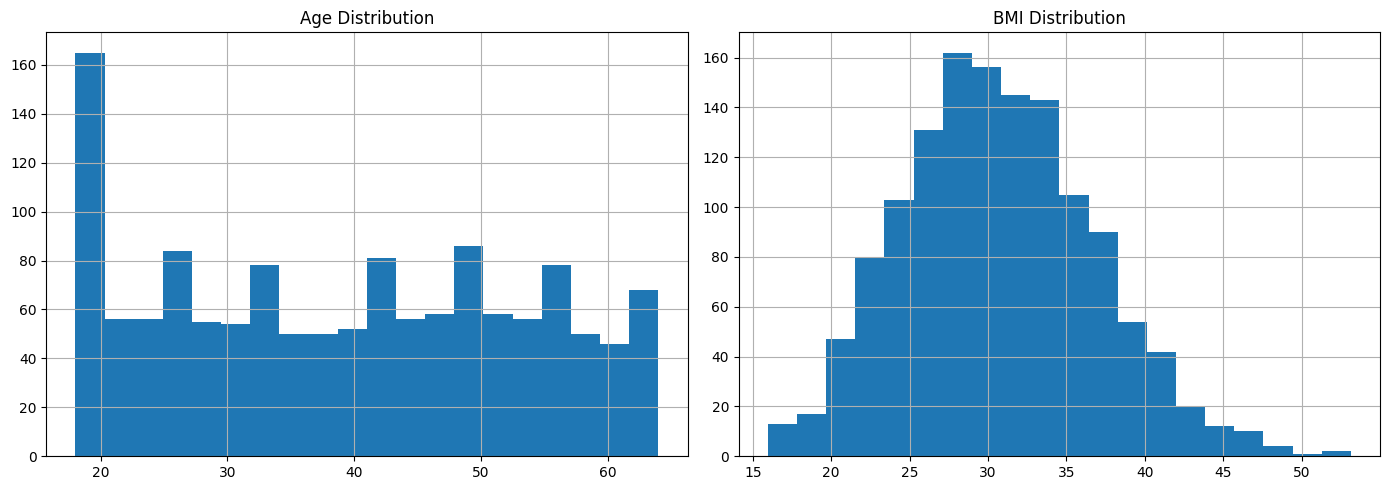

In [35]:
# Age & BMI after feature engineering
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

df["age"].hist(ax=ax[0], bins=20)
ax[0].set_title("Age Distribution")

df["bmi"].hist(ax=ax[1], bins=20)
ax[1].set_title("BMI Distribution")

plt.tight_layout()
plt.show()

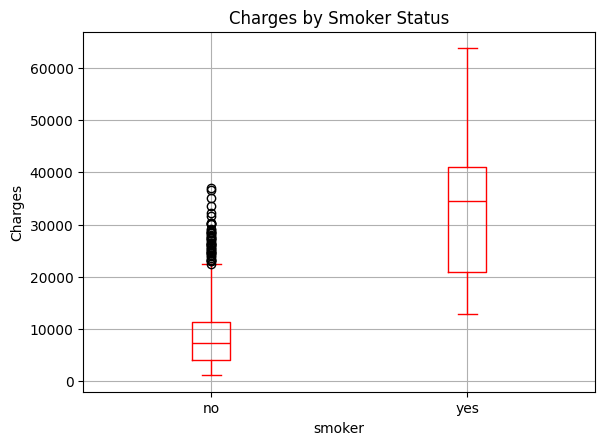

In [37]:
df.boxplot(column="charges", by="smoker",color='red')
plt.title("Charges by Smoker Status")
plt.suptitle("")
plt.ylabel("Charges")
plt.show()

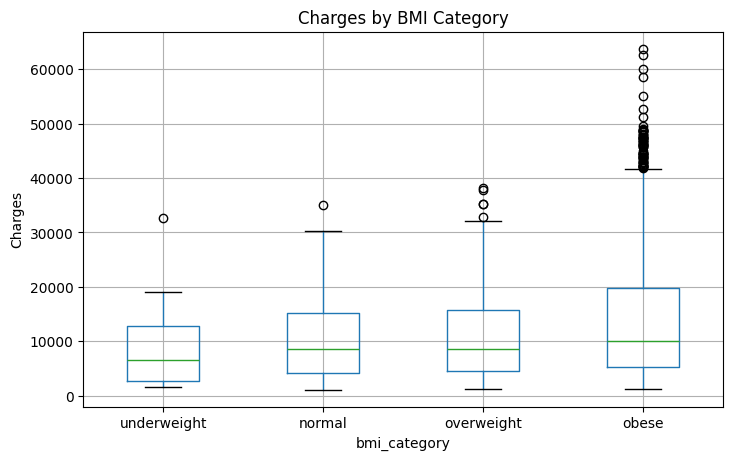

In [38]:
df.boxplot(column="charges", by="bmi_category", figsize=(8,5))
plt.title("Charges by BMI Category")
plt.suptitle("")
plt.ylabel("Charges")
plt.show()

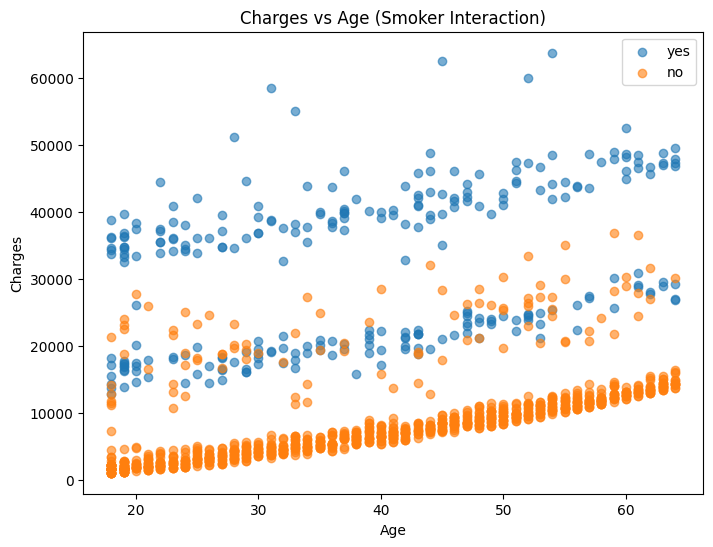

In [39]:
plt.figure(figsize=(8,6))
for s in df["smoker"].unique():
    subset = df[df["smoker"] == s]
    plt.scatter(subset["age"], subset["charges"], label=s, alpha=0.6)

plt.xlabel("Age")
plt.ylabel("Charges")
plt.title("Charges vs Age (Smoker Interaction)")
plt.legend()
plt.show()

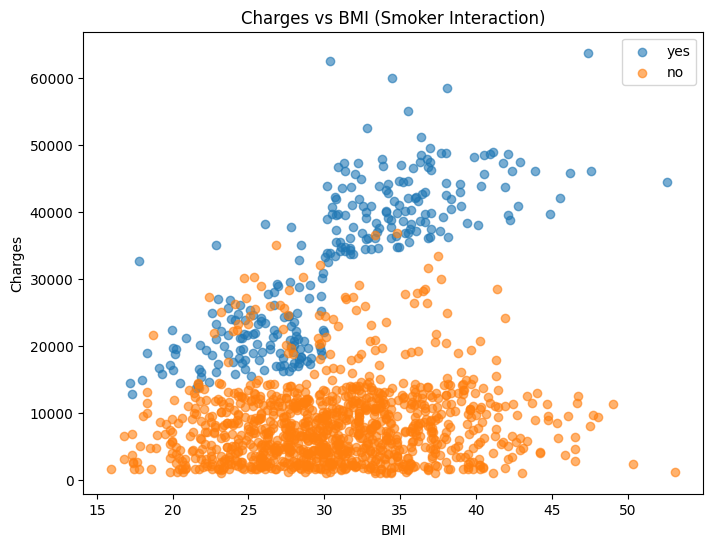

In [40]:
plt.figure(figsize=(8,6))
for s in df["smoker"].unique():
    subset = df[df["smoker"] == s]
    plt.scatter(subset["bmi"], subset["charges"], label=s, alpha=0.6)

plt.xlabel("BMI")
plt.ylabel("Charges")
plt.title("Charges vs BMI (Smoker Interaction)")
plt.legend()
plt.show()

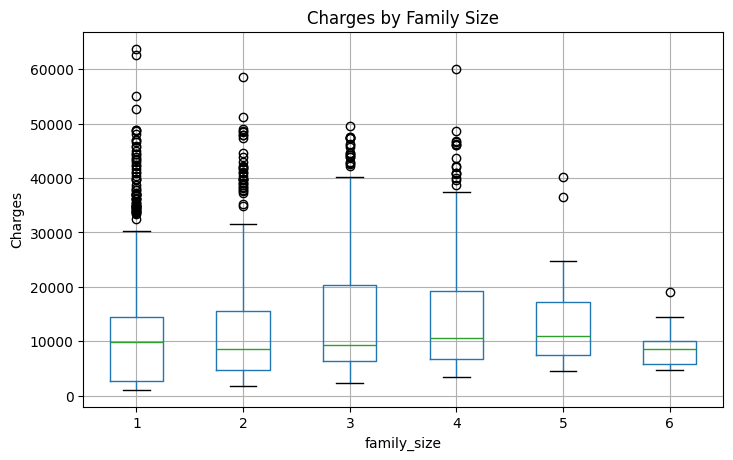

In [41]:
df.boxplot(column="charges", by="family_size", figsize=(8,5))
plt.title("Charges by Family Size")
plt.suptitle("")
plt.ylabel("Charges")
plt.show()


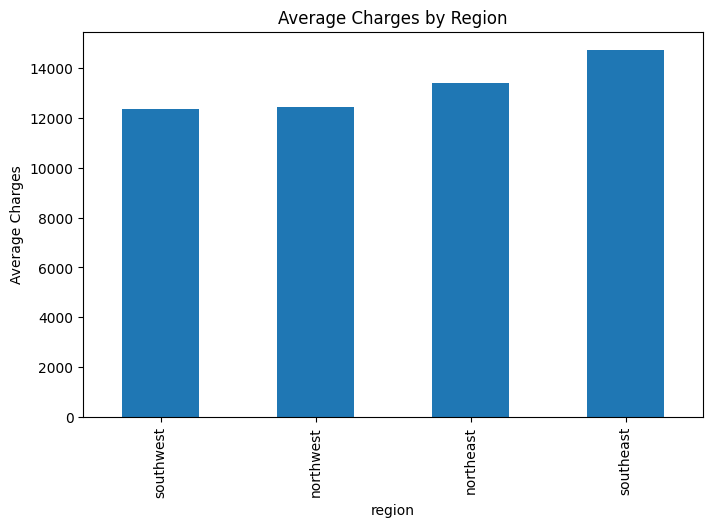

In [42]:
df.groupby("region")["charges"].mean().sort_values().plot(
    kind="bar",
    figsize=(8,5),
    title="Average Charges by Region"
)
plt.ylabel("Average Charges")
plt.show()


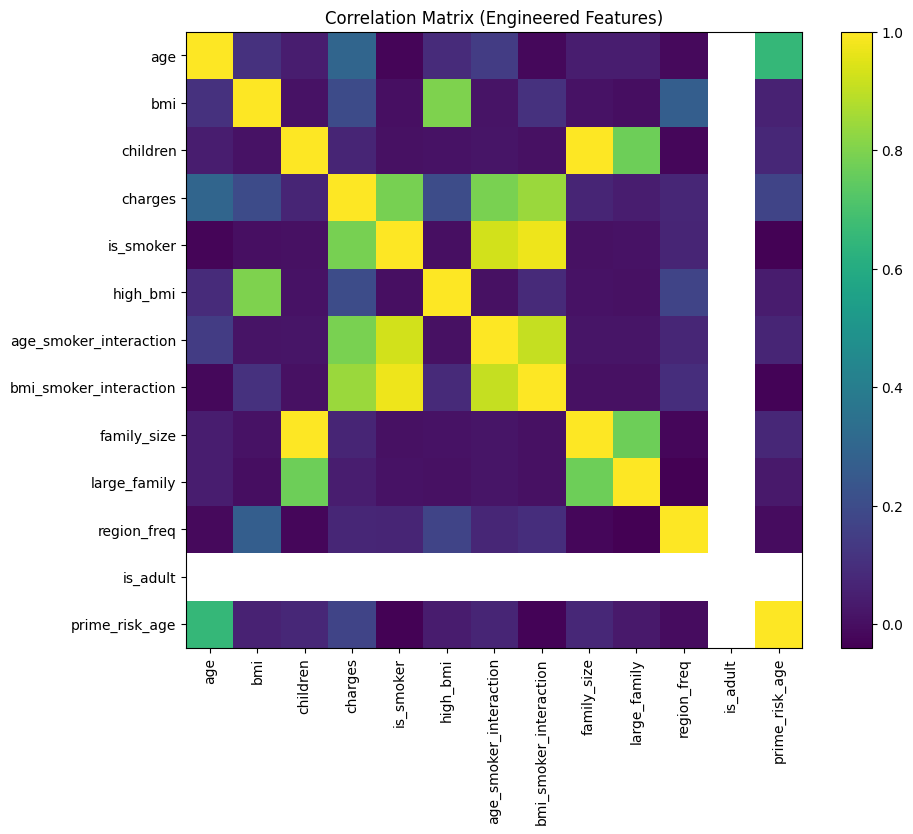

In [43]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns

corr = df[numeric_cols].corr()

plt.figure(figsize=(10,8))
plt.imshow(corr)
plt.colorbar()
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)
plt.title("Correlation Matrix (Engineered Features)")
plt.show()

In [45]:
df.dtypes

age                          int64
sex                         object
bmi                        float64
children                     int64
smoker                      object
region                      object
charges                    float64
age_group                 category
bmi_category              category
is_smoker                    int64
high_bmi                     int64
age_smoker_interaction       int64
bmi_smoker_interaction     float64
family_size                  int64
large_family                 int64
region_freq                float64
region_smoker               object
is_adult                     int64
prime_risk_age               int64
dtype: object

In [46]:
# 💾 Save Final Engineered Features (Human-Readable CSV)
select_columns=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges', 'is_smoker',
       'age_smoker_interaction', 'bmi_smoker_interaction', 'family_size',
       'prime_risk_age']
df[select_columns].to_csv('/workspaces/End_to_end_insurance_price_predection/data/processed/insurance_fe',index=False)

print("✅ Saved human-readable engineered features to workspaces/End_to_end_insurance_price_predection/data/processed/insurance_fe")

✅ Saved human-readable engineered features to workspaces/End_to_end_insurance_price_predection/data/processed/insurance_fe
